In [1]:
%matplotlib inline
import cmlreaders as cml
import pybeh_pd as pb
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
all_fr1_events = cml.CMLReader.load_events(experiments=["FR1"])

In [3]:
events = all_fr1_events.query('type == ["WORD", "REC_WORD"]')
events = events.assign(row_order=range(len(events)))
events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0] # removing practice lists

#removing subjects who were presented with the same word multiple times (probably repeated data)
word_evs = events.query('type == "WORD"')
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num'], as_index=False).size()
bad_lists = n_word_pres.query('size >= 2')
bad_subs = bad_lists.subject.unique().tolist()

#drop subjects without 12 items per list
n_list_pres = word_evs.groupby(['subject', 'session', 'list'], as_index=False).size()
bad_lists = n_list_pres.query('size != 12')
bad_subs += bad_lists.subject.unique().tolist()

#drop subjects with no recalls
n_types = events.groupby('subject', as_index=False).agg({'type': 'nunique'})
no_recall_subs = n_types.query('type != 2')
bad_subs += no_recall_subs.subject.unique().tolist()

#drop subs with messed up recalls
rec_evs = events.query('type == "REC_WORD"')
joint_evs = word_evs.merge(rec_evs[['subject', 'session', 'list', 'item']], how='left', indicator=True)
bad_subs += joint_evs.query('(recalled == 1 and _merge != "both") or (recalled == 0 and _merge == "both")').subject.unique().tolist()

events.query('subject not in @bad_subs', inplace=True)

In [4]:
#fixing serial position in REC_WORD events
events.loc[events['type'] == "REC_WORD", "serialpos"] = np.nan
events.sort_values('type', inplace=True)
#bfill because WORD will come after REC_WORD after sorting
events['serialpos'] = events.groupby(['subject', 'session', 'list', 'item'])['serialpos'].bfill()
events.sort_values('row_order', inplace=True)

In [5]:
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')

In [6]:
spc_sess_df = word_evs.groupby(['subject', 'session', 'serialpos'], as_index=False).agg({'recalled': 'mean'})
spc_df = spc_sess_df.groupby(['subject', 'serialpos'], as_index=False).agg({'recalled': 'mean'})

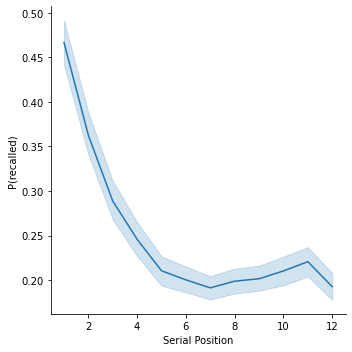

In [7]:
g = sns.relplot(x='serialpos', y='recalled', data=spc_df, kind='line')
g.set(xlabel='Serial Position', ylabel='P(recalled)')

In [8]:
rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
n_list_df = word_evs.groupby(['subject', 'session'], as_index=False).agg({'list': 'nunique'}).rename(columns={'list': 'n_lists'})
first_recall_sess_df = rec_evs.query('outpos == 0 and serialpos != -999') #don't include intrusions (i.e., serialpos == -999)

#make sure there are 0s in serialpos that never get recalled first
first_recall_sess_df = first_recall_sess_df.groupby(
    ['subject', 'session', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()

first_recall_sess_df = first_recall_sess_df.merge(n_list_df)
first_recall_sess_df['pfr'] = first_recall_sess_df['recalled'] / first_recall_sess_df['n_lists']
pfr_df = first_recall_sess_df.groupby(['subject', 'serialpos'], as_index=False).agg({'pfr': 'mean'})

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


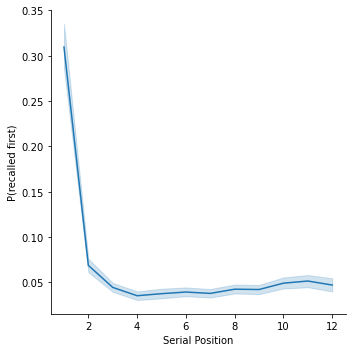

In [9]:
g = sns.relplot(x='serialpos', y='pfr', data=pfr_df, kind='line')
g.set(xlabel='Serial Position', ylabel='P(recalled first)')

In [19]:
rec_evs['repeat'] = rec_evs.duplicated(subset=['subject', 'session', 'list', 'item'])
rec_evs['correct'] = (rec_evs['repeat'] == False) & (rec_evs['intrusion'] == 0)
rec_evs['next_rectime'] = rec_evs.groupby(['subject', 'session', 'list']).rectime.shift(-1)
rec_evs['next_correct'] = rec_evs.groupby(['subject', 'session', 'list']).correct.shift(-1)
rec_evs['irt'] = rec_evs['next_rectime'] - rec_evs['rectime']
rec_evs.loc[(rec_evs['correct'] == False) | (rec_evs['next_correct'] == False), 'irt'] = np.nan
rec_evs['correct_outpos'] = rec_evs.groupby(['subject', 'session', 'list'])['correct'].cumsum()
rec_evs['n_correct'] = rec_evs.groupby(['subject', 'session', 'list'])['correct_outpos'].transform('max')
rec_evs['irt_s'] = rec_evs['irt'] / 1000
rec_evs['next_serialpos'] = rec_evs.groupby(['subject', 'session', 'list']).serialpos.shift(-1)
rec_evs['transition'] = rec_evs['next_serialpos'] - rec_evs['serialpos']
rec_evs.loc[(rec_evs['correct'] == False) | (rec_evs['next_correct'] == False), 'transition'] = np.nan

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [14]:
irt_sess_df = rec_evs.groupby(['subject', 'session', 'correct_outpos', 'n_correct'], as_index=False).agg({'irt_s': 'mean'})
irt_df = irt_sess_df.groupby(['subject', 'correct_outpos', 'n_correct'], as_index=False).agg({'irt_s': 'mean'})

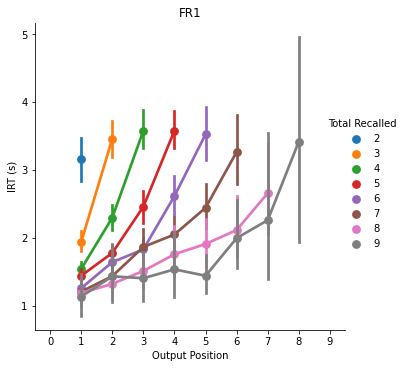

In [17]:
g = sns.catplot(x='correct_outpos', y='irt_s', hue='n_correct', data=irt_df.query('n_correct > 1 and n_correct < 10'), kind='point')
g.set(xlabel='Output Position', ylabel='IRT (s)', title='FR1')
g._legend.set_title('Total Recalled')

In [ ]:
crl_sess_df = rec_evs.groupby(['subject', 'session', 'transition'], as_index=False).agg({'irt_s': 'mean'})
crl_df = crl_sess_df.groupby(['subject', 'transition'], as_index=False).agg({'irt_s': 'mean'})

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


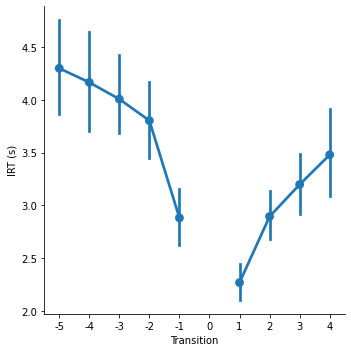

In [20]:
g = sns.catplot(x='transition', y='irt_s', data=crl_df.query('abs(transition) < 6'),
                order=np.arange(-5, 5),
                kind='point')
g.set(xlabel='Transition', ylabel='IRT (s)')

In [22]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

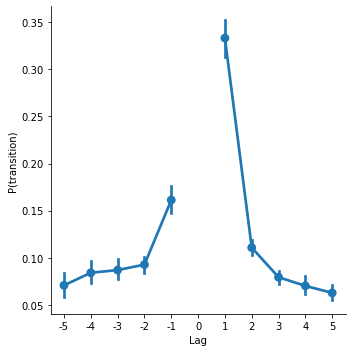

In [23]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5'))
g.set(xlabel='Lag', ylabel='P(transition)')

In [24]:
#probably the correct way to do it (aggregating at all levels), but as far as I know not how we have done it in the past -- takes a little while to run
pb_crp_list = events.groupby(['subject', 'session', 'list']).apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

In [26]:
pb_crp_sess = pb_crp_list.groupby(['subject', 'session', 'lag']).agg({'prob': 'mean'}).reset_index()
pb_crp2 = pb_crp_sess.groupby(['subject', 'lag']).agg({'prob': 'mean'}).reset_index()

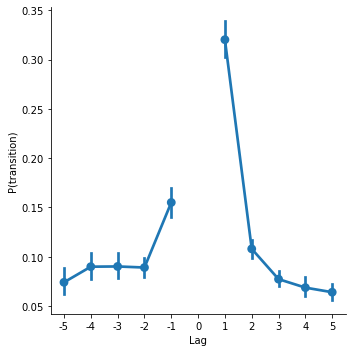

In [27]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp2.query('lag <= 5 and lag >= -5'))
g.set(xlabel='Lag', ylabel='P(transition)')

In [28]:
pb_temp_fact = events.groupby("subject").apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,temp_fact
0,R1001P,0.625303
1,R1002P,0.602389
2,R1003P,0.697490
3,R1006P,0.674832
4,R1010J,0.603109
...,...,...
262,R1467M,0.626045
263,R1542J,0.562895
264,R1569T,0.758442
265,R1571T,0.741228


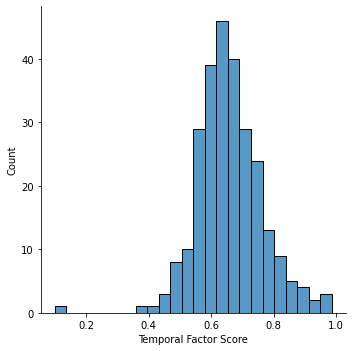

In [30]:
g = sns.displot(x='temp_fact', data=pb_temp_fact)
g.set(xlabel='Temporal Factor Score')

In [36]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df['item_num'] = item_num_df['item_num'] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [54]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [55]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [56]:
# get all pairs of items
items = item_num_df.item.values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['wordpool_item_1', 'wordpool_item_2']).to_frame(index=False)

In [57]:
sem_sim_df

,wordpool_item_1,wordpool_item_2
0,HOUSE,HOUSE
1,HOUSE,HAWK
2,HOUSE,WAND
3,HOUSE,GEESE
4,HOUSE,STAR
...,...,...
563996,VIGA,PECHO
563997,VIGA,CAMELLO
563998,VIGA,INUNDACION
563999,VIGA,BEBE


In [67]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='wordpool_item_1', 
               col2='wordpool_item_2', 
               keyed_vector=word2vec_vectors)

In [68]:
sem_sim_df.to_csv('/scratch/djh/fr1_sem_sim_df.csv', index=False)

In [69]:
sem_sim_df = pd.read_csv('/scratch/djh/fr1_sem_sim_df.csv')

In [70]:
sem_sim_df

,wordpool_item_1,wordpool_item_2,similarity
0,HOUSE,HOUSE,1.000000
1,HOUSE,HAWK,0.113100
2,HOUSE,WAND,0.093160
3,HOUSE,GEESE,0.057868
4,HOUSE,STAR,0.063717
...,...,...,...
563996,VIGA,PECHO,NaN
563997,VIGA,CAMELLO,NaN
563998,VIGA,INUNDACION,NaN
563999,VIGA,BEBE,NaN


In [71]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='wordpool_item_1', right_on='item').merge(
    item_num_df, left_on='wordpool_item_2', right_on='item', suffixes=('_1', '_2')).drop(columns=['wordpool_item_1', 'wordpool_item_2'])

In [72]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [73]:
sem_sim_num_df

,similarity,item_num_1,item_1,item_num_2,item_2
0,1.000000,1,HOUSE,1,HOUSE
1,0.113100,2,HAWK,1,HOUSE
2,0.093160,3,WAND,1,HOUSE
3,0.057868,4,GEESE,1,HOUSE
4,0.063717,5,STAR,1,HOUSE
...,...,...,...,...,...
563996,NaN,747,PECHO,751,VIGA
563997,NaN,748,CAMELLO,751,VIGA
563998,NaN,749,INUNDACION,751,VIGA
563999,NaN,750,BEBE,751,VIGA


In [74]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

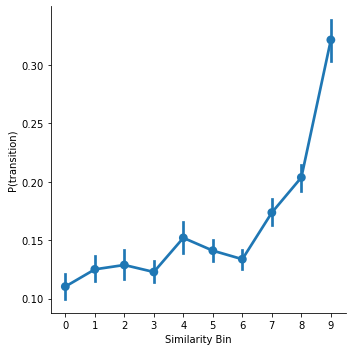

In [75]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp)
g.set(xlabel='Similarity Bin', ylabel='P(transition)')

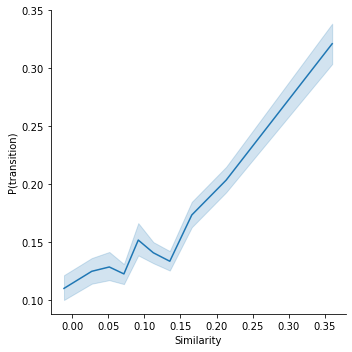

In [76]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.relplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp, kind='line')
g.set(xlabel='Similarity', ylabel='P(transition)')

In [47]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False
                                                       ).to_frame(name='sem_fact').reset_index()

pb_sem_dist_fact

,subject,sem_fact
0,R1001P,0.550296
1,R1002P,0.548142
2,R1003P,0.545138
3,R1006P,0.550895
4,R1010J,0.650000
...,...,...
262,R1467M,0.647275
263,R1542J,0.570793
264,R1569T,0.579774
265,R1571T,0.640936


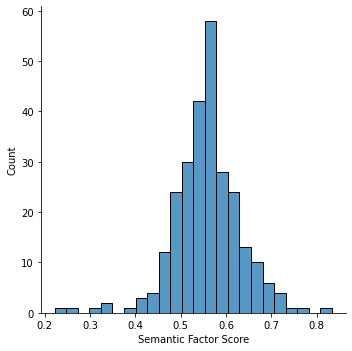

In [48]:
g = sns.displot(x='sem_fact', data=pb_sem_dist_fact)
g.set(xlabel='Semantic Factor Score')